Matplotlib is building the font cache; this may take a moment.


D:\python\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
D:\python\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 52s 195ms/step - accuracy: 0.2060 - loss: 2.2848 - val_accuracy: 0.1721 - val_loss: 2.4901
Epoch 2/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 43s 192ms/step - accuracy: 0.2500 - loss: 1.8035 - val_accuracy: 0.2257 - val_loss: 2.0259
Epoch 3/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 43s 190ms/step - accuracy: 0.2871 - loss: 1.7406 - val_accuracy: 0.3729 - val_loss: 1.6111
Epoch 4/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 196ms/step - accuracy: 0.3232 - loss: 1.6824 - val_accuracy: 0.3234 - val_loss: 1.9255
Epoch 5/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - accuracy: 0.3461 - loss: 1.6504 - val_accuracy: 0.3643 - val_loss: 1.6455
Epoch 6/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 193ms/step - accuracy: 0.3636 - loss: 1.6104 - val_accuracy: 0.4045 - val_loss: 1.4847
Epoch 7/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.3817 - loss: 1.5831 - val_accuracy: 0.4420 - val_loss: 1.4451
Epoch 8/150
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.3998 -

Model saved as emotion_recognition_model.h5


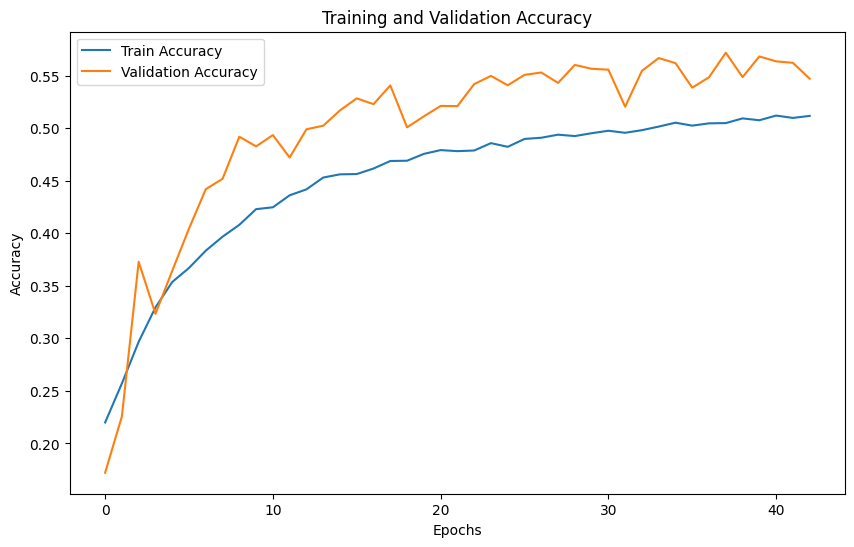

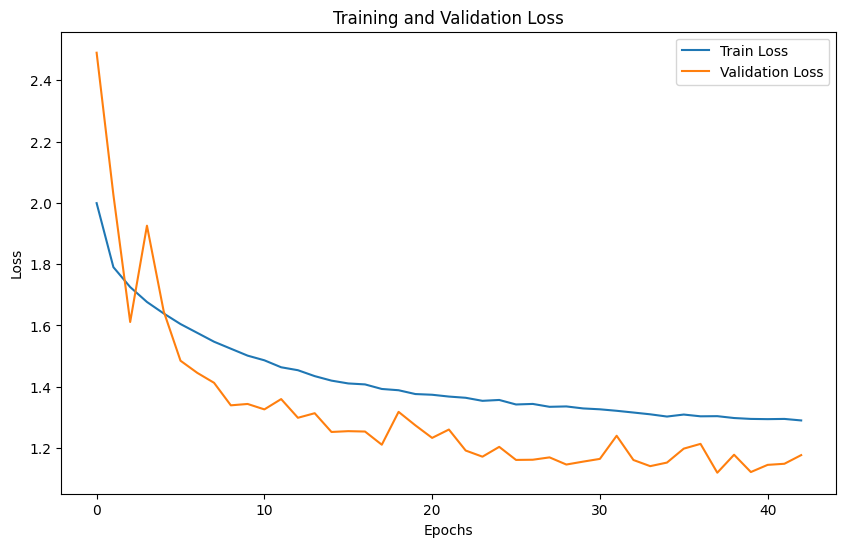

In [3]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Fixed import
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Function to create DataFrame
def createDataFrame(dir):
    image_path = []
    labels = []

    for label in os.listdir(dir):
        label_path = os.path.join(dir, label)
        if os.path.isdir(label_path):  
            for imagename in os.listdir(label_path):  
                image_path.append(os.path.join(label_path, imagename))
                labels.append(label)
    return image_path, labels

# Load Training Data
train_data_dir = 'D:/python/images/train'
train = pd.DataFrame()
train['image'], train['label'] = createDataFrame(train_data_dir)

# Load Test Data
test_data_dir = 'D:/python/images/test'
test = pd.DataFrame()
test['image'], test['label'] = createDataFrame(test_data_dir)

# Function to Extract Features
from tqdm import tqdm

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode="grayscale", target_size=(48, 48))  # Resize to 48x48
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

# Extract Features
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

# Normalize Images
x_train = train_features / 255.0
x_test = test_features / 255.0

# Encode Labels
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

# Model Architecture
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(7, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=150,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

# Save Model
model.save('emotion_recognition_model.h5')
print("Model saved as emotion_recognition_model.h5")

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
